In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv('gold_monthly_csv.csv')
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [25]:
df.shape

(847, 2)

In [26]:
## getting date range
print(f"Date range of gold prices is from : {df['Date'].min()} to {df['Date'].max()}")

Date range of gold prices is from : 1950-01 to 2020-07


In [27]:
## creating a monthly date range
date = pd.date_range(start= '1/1/1950', end='8/1/2020', freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [28]:
# add the date to dataframe
df['month'] = date

# drop Date column
df.drop('Date', axis=1, inplace=True)
df=df.set_index('month')

df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


<Figure size 2400x1000 with 0 Axes>

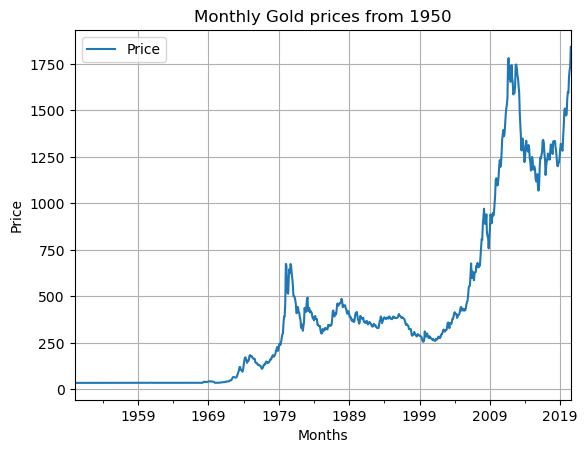

In [29]:
## Quick EDA
# monthly gold prices from 1950

plt.figure(figsize=(24, 10))
df.plot()
plt.title("Monthly Gold prices from 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid()
plt.show()

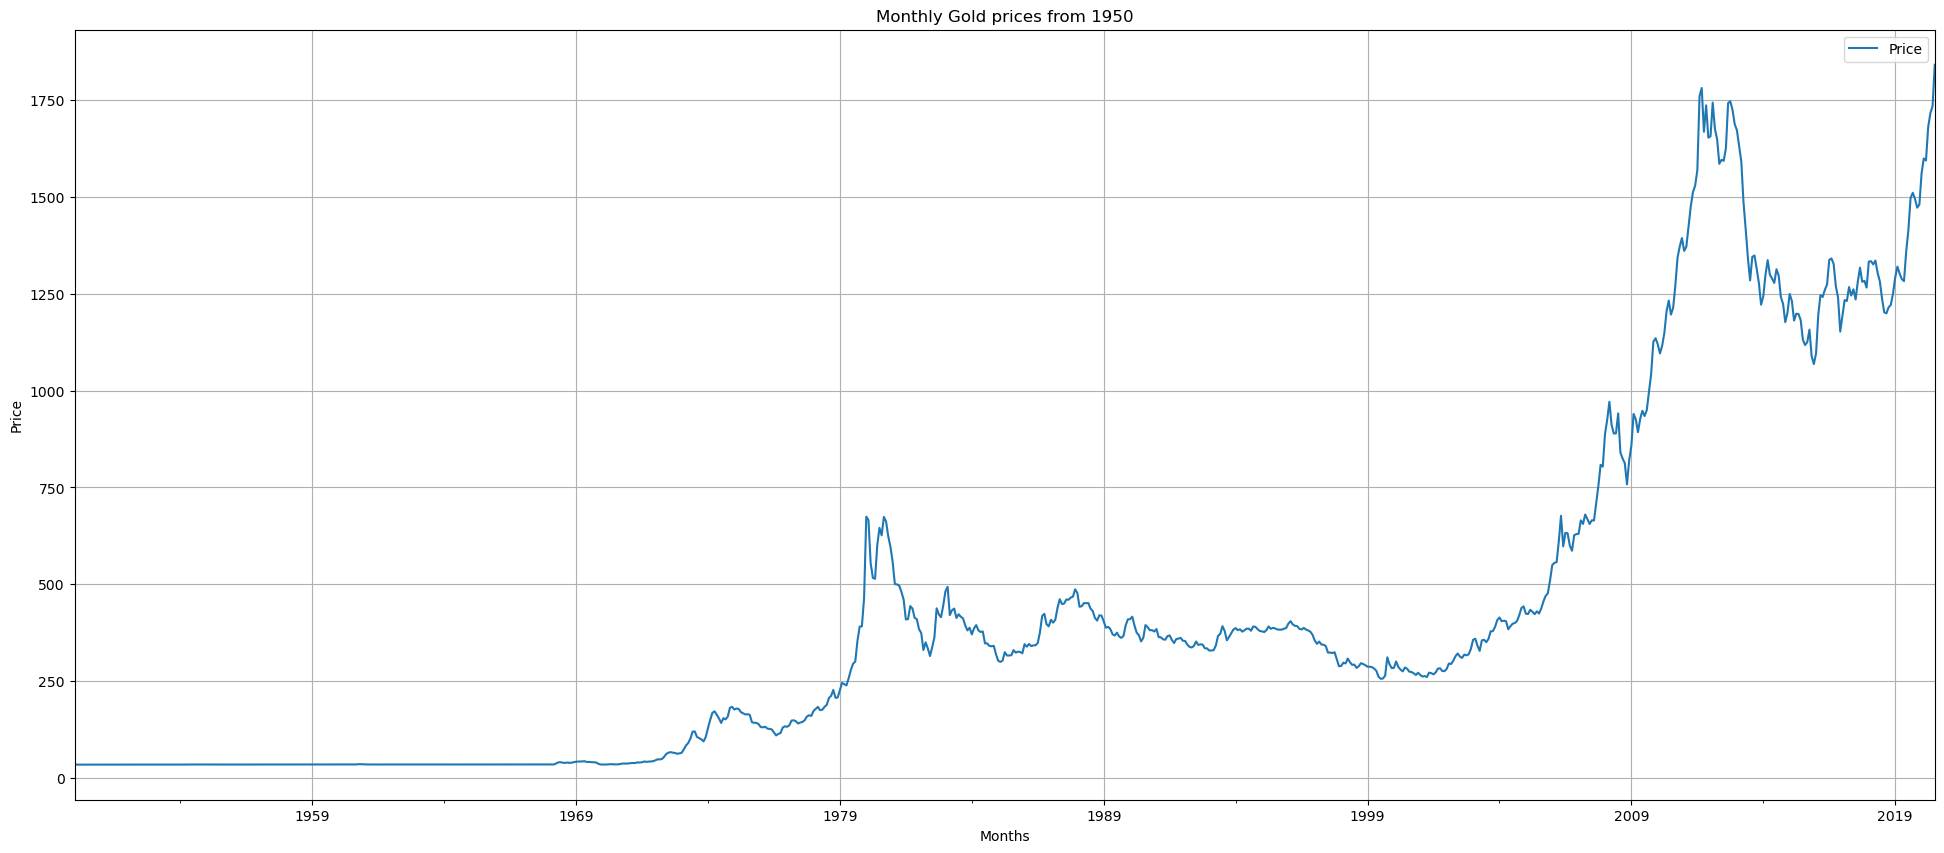

In [30]:
df.plot(figsize=(24, 10))
plt.title("Monthly Gold prices from 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid()
plt.show()

In [31]:
df.describe()

,Price
count,847.000000
mean,416.556906
std,453.665313
min,34.490000
25%,35.190000
50%,319.622000
75%,447.029000
max,1840.807000


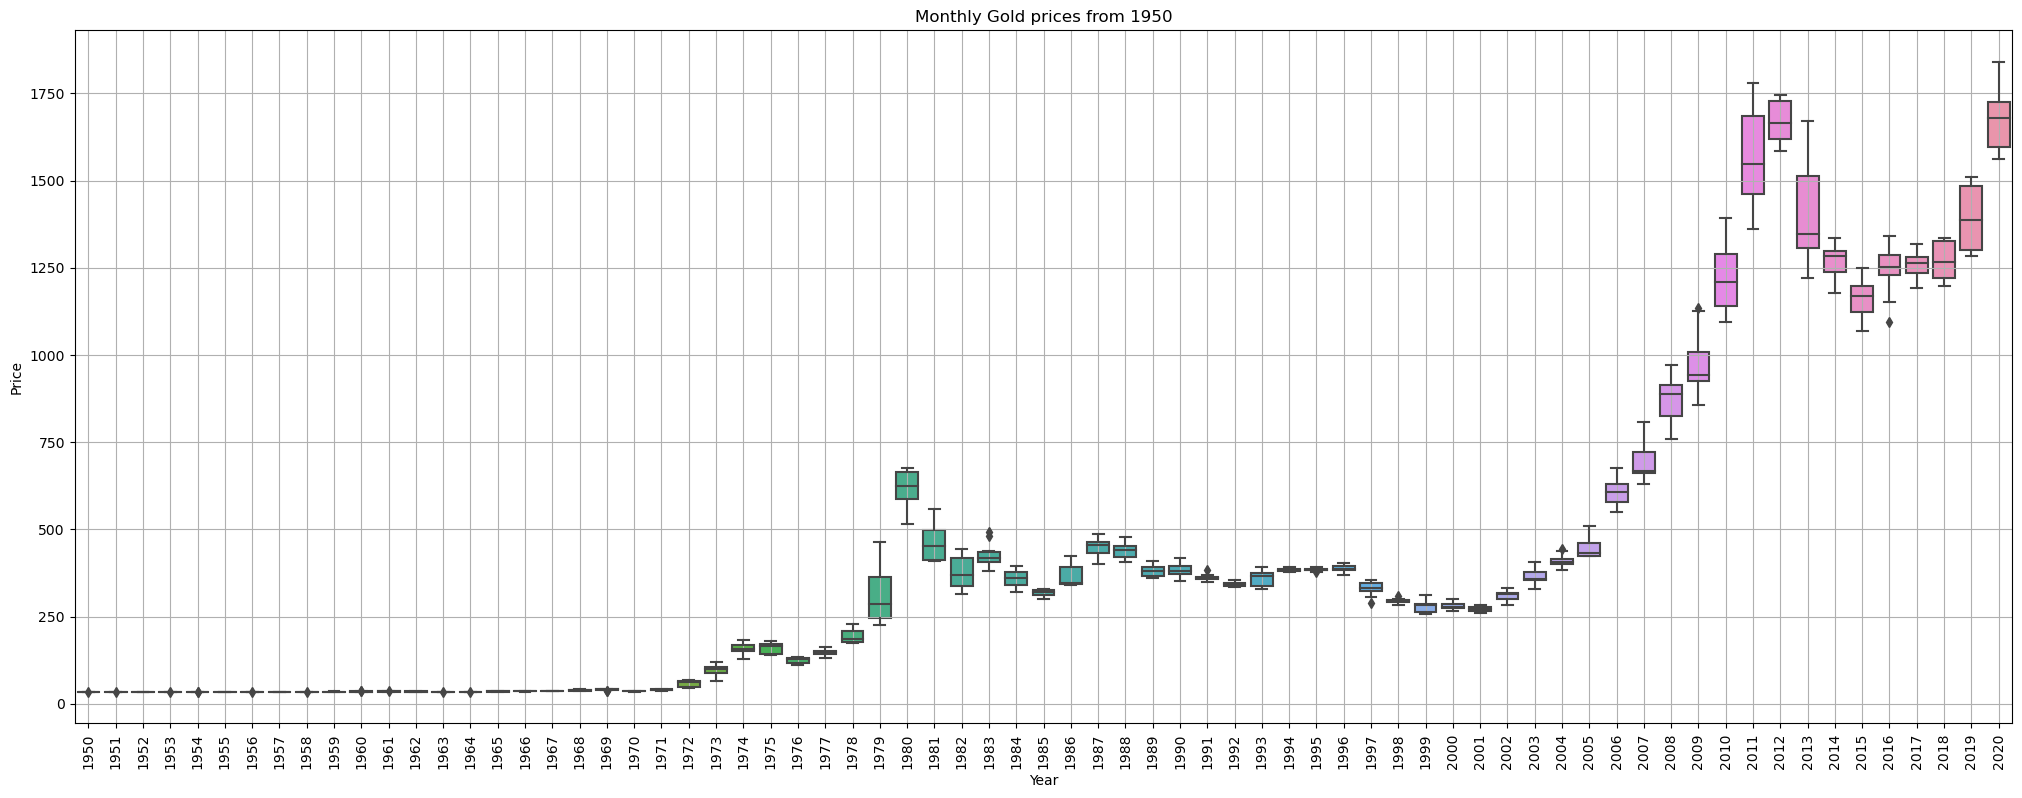

In [35]:
# visual 2

_, ax =plt.subplots(figsize=(25,9))
sns.boxplot(x = df.index.year, y = df.values[:,0], ax=ax)
plt.title("Monthly Gold prices from 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.xticks(rotation =90)
plt.grid();

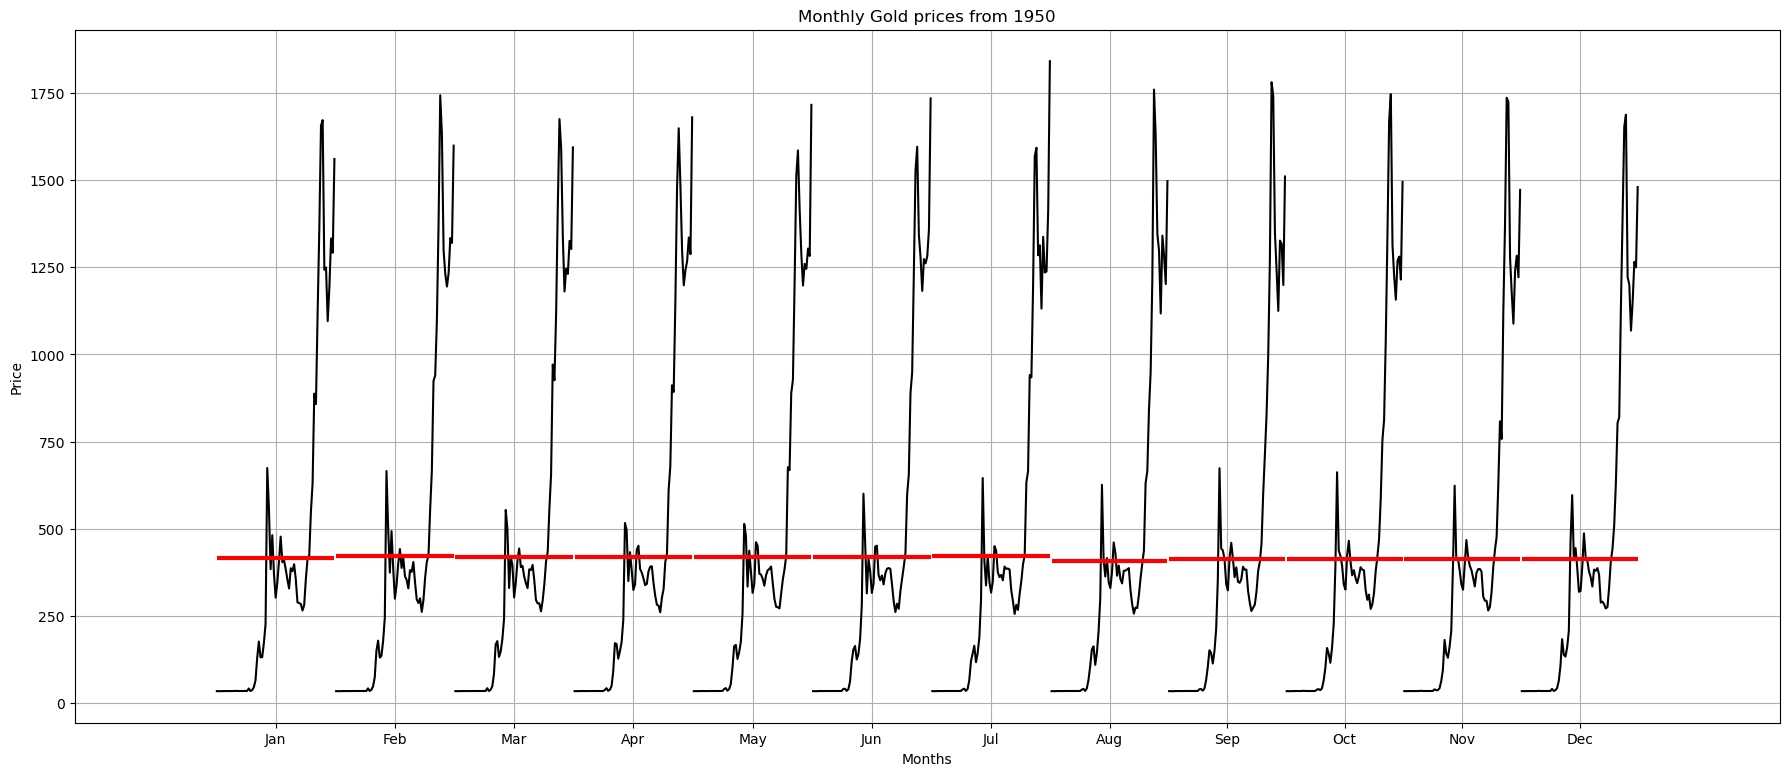

In [36]:
## month plot graph

from statsmodels.graphics.tsaplots import month_plot

fig, ax=plt.subplots(figsize=(22,9))
month_plot(df, ylabel='Gold Price', ax=ax)
plt.title("Monthly Gold prices from 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid()
plt.show()

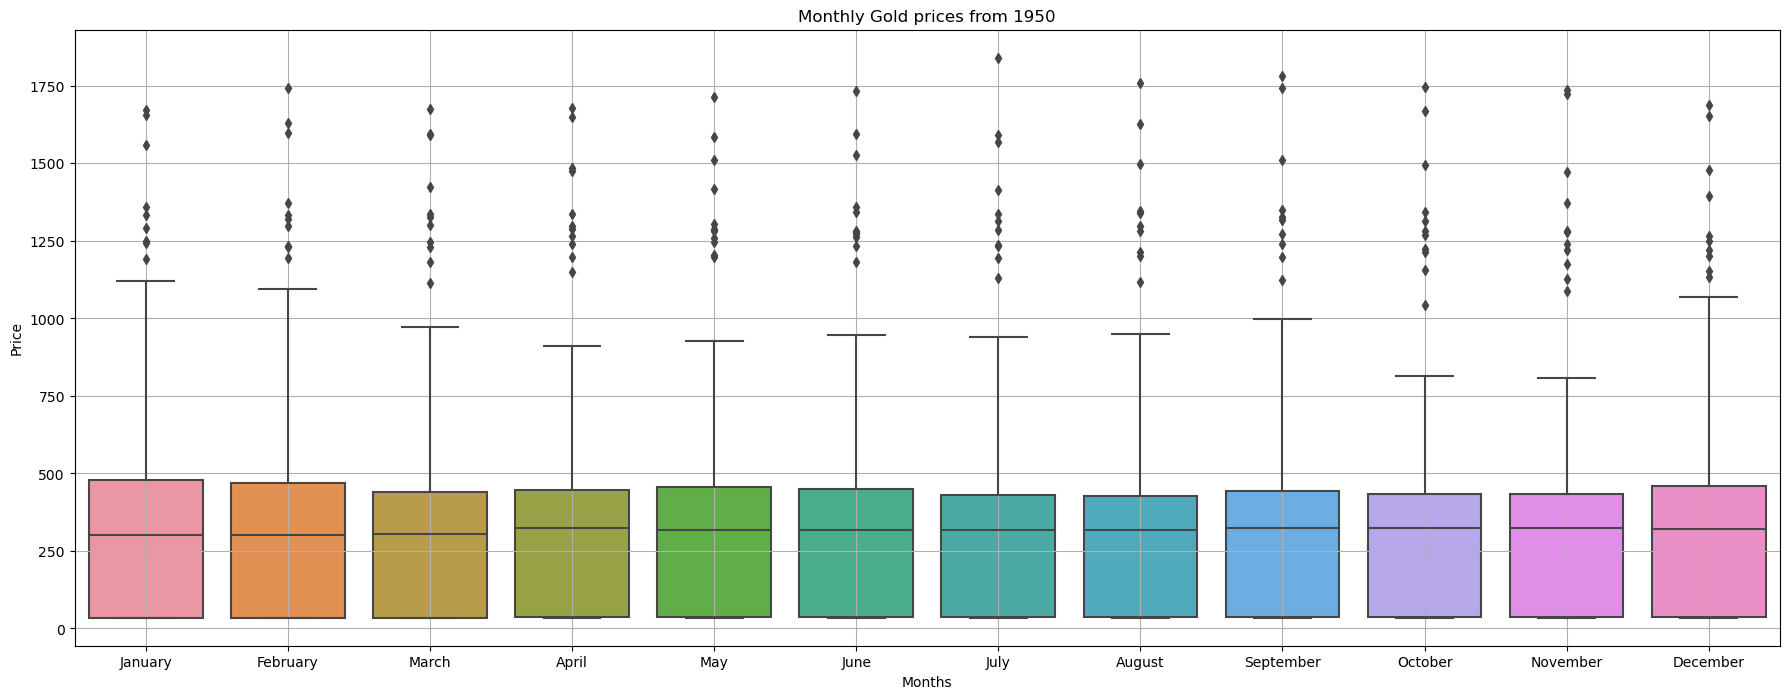

In [38]:
# month boxplot

_, ax=plt.subplots(figsize=(22, 8))
sns.boxplot(x= df.index.month_name(), y=df.values[:,0], ax=ax)
plt.title("Monthly Gold prices from 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid()
plt.show()

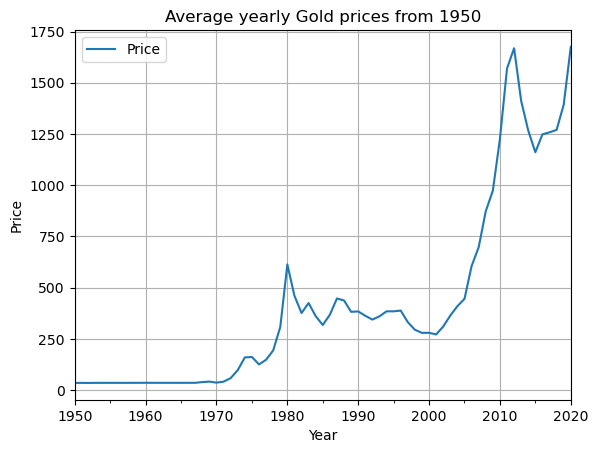

In [43]:
# yearly average gold price

df_yearly_avgsum = df.resample('A').mean()
df_yearly_avgsum.plot()
plt.title("Average yearly Gold prices from 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()
plt.show()

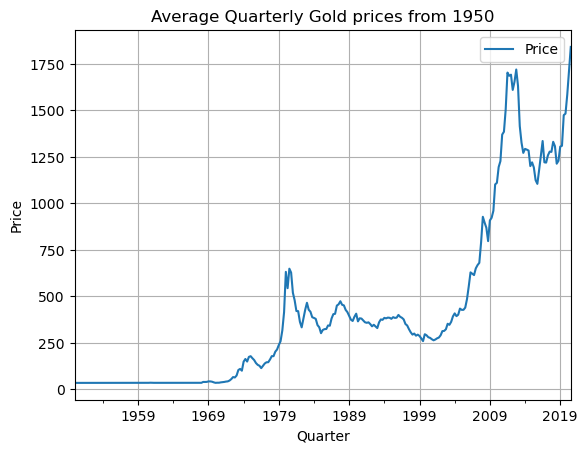

In [44]:
# average quaterly gold price

df_quarter_avgsum = df.resample('Q').mean()
df_quarter_avgsum.plot()
plt.title("Average Quarterly Gold prices from 1950")
plt.xlabel("Quarter")
plt.ylabel("Price")
plt.grid()
plt.show()

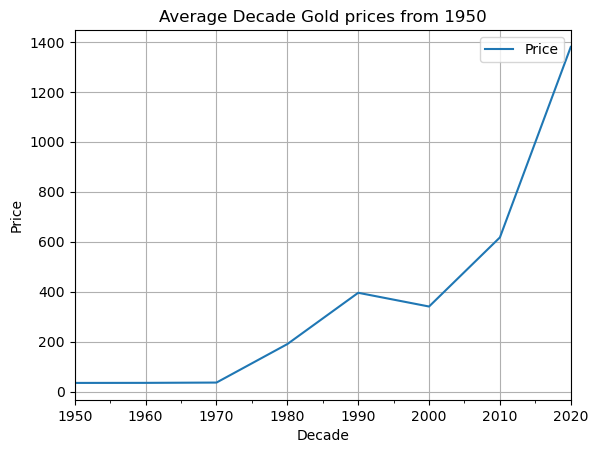

In [45]:
# average gold price in decades

df_decade_avgsum = df.resample('10Y').mean()
df_decade_avgsum.plot()
plt.title("Average Decade Gold prices from 1950")
plt.xlabel("Decade")
plt.ylabel("Price")
plt.grid()
plt.show()

Cooefficient of variation CV of prices

The coefficient of variation (CV) is a statistical measure that quantifies the relative variability or dispersion of a dataset. It is expressed as a percentage and is calculated as the ratio of the standard deviation to the mean (average) of the data. 

In other words:
CV = (Standard Deviation / Mean​)×100%

Allows investors to calculate amount of volatility and rewards to expect from investment

In [47]:
df_1= df.groupby(df.index.year).mean().rename(columns= {'Price': 'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price': 'Std'}), left_index=True, right_index=True)
df_1['COV_P'] = ((df_1['Std'] / df_1['Mean'])*100).round(2)

df_1.head()

,Mean,Std,COV_P
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


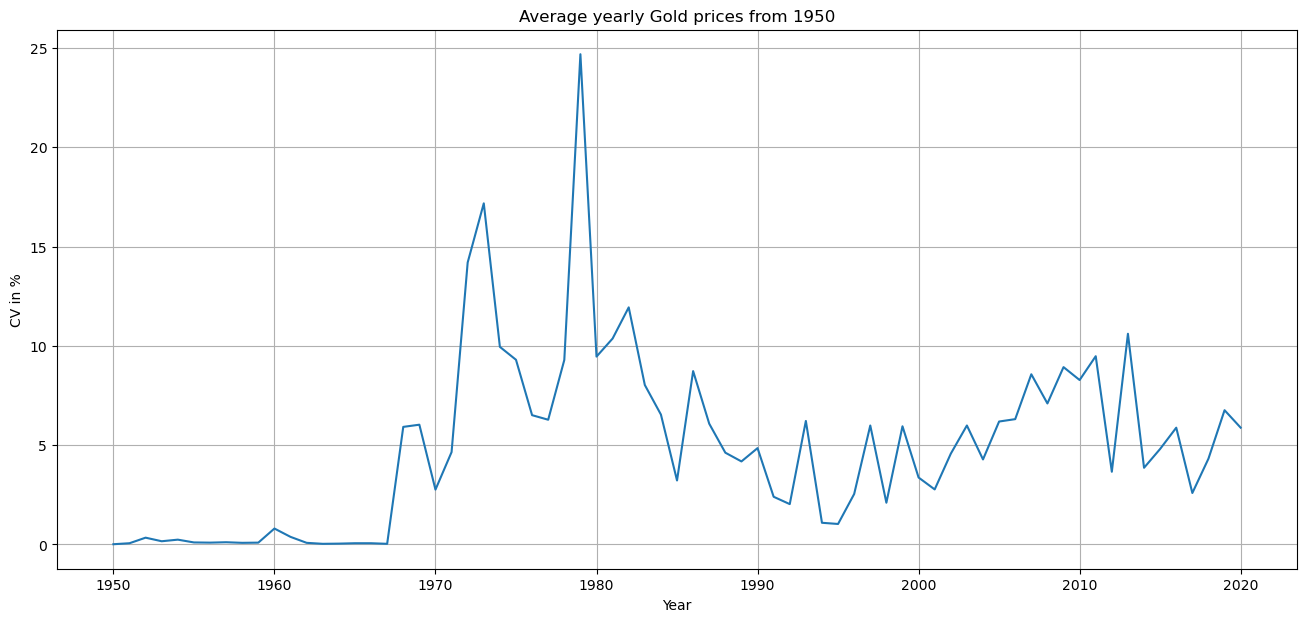

In [48]:
# plot

fig, ax =plt.subplots(figsize=(16,7))
df_1['COV_P'].plot()
plt.title("Average yearly Gold prices from 1950")
plt.xlabel("Year")
plt.ylabel("CV in %")
plt.grid()
plt.show()

### Timeseries Forecasting

In [49]:
# split to train and test dataset

train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]

In [50]:
train.shape

(792, 1)

In [51]:
test.shape

(55, 1)

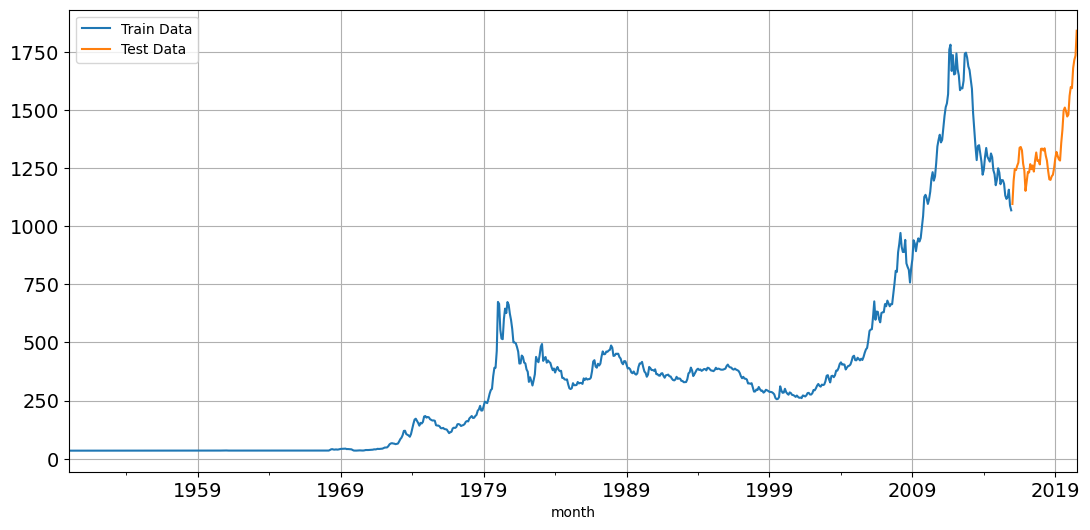

In [54]:
train['Price'].plot(figsize=(13, 6), fontsize = 14)
test['Price'].plot(figsize=(13, 6), fontsize = 14)

plt.grid()
plt.legend(['Train Data', 'Test Data'])
plt.show()

##### Models

In [55]:
## Linear regression

train_time = [i + 1 for i in range(len(train))]
test_time = [i + len(train) + 1 for i in range(len(test))]

len(train_time), len(test_time)

(792, 55)

In [56]:
len(train_time)

792

In [57]:
len(test_time)

55

In [58]:
## lr df

lr_train = train.copy()

lr_test = test.copy()

In [59]:
## add train and test time to them

lr_train['time'] = train_time

lr_test['time'] = test_time

In [60]:
#instantiate LR

LR = LinearRegression()

LR.fit(lr_train[['time']], lr_train['Price'].values)

LinearRegression()

In [61]:
## prediction

test_predic_model1 = LR.predict(lr_test[['time']])

#add predict to test
lr_test['forecast'] = test_predic_model1

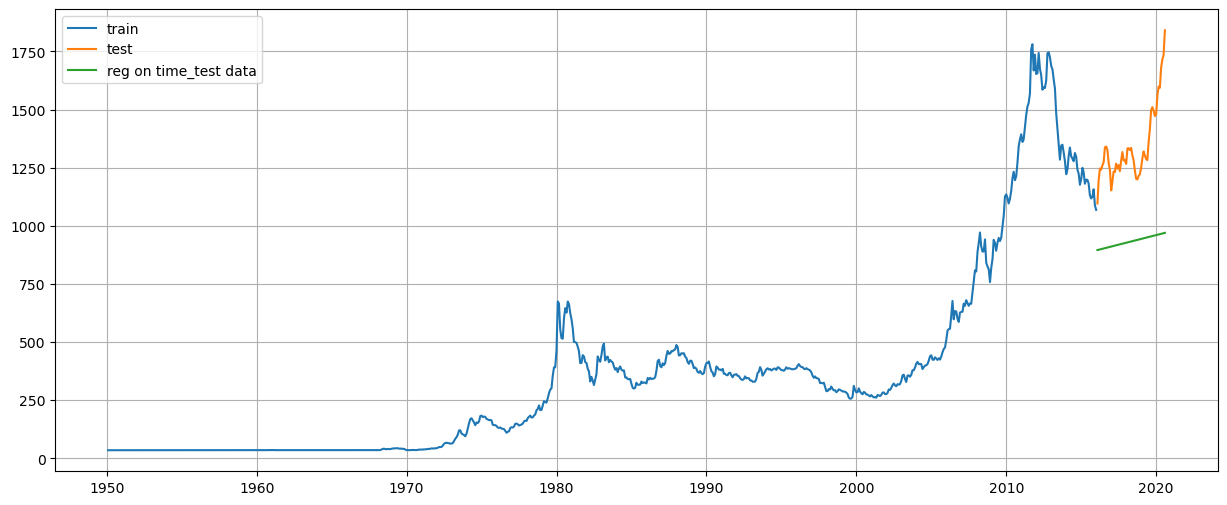

In [62]:
##plots

plt.figure(figsize=(15,6))
plt.plot(train['Price'], label='train')
plt.plot(test['Price'], label='test')
plt.plot(lr_test['forecast'], label='reg on time_test data')
plt.legend(loc = "best")
plt.grid()

MAPE

Mean Absolute Percentage Error (MAPE) is a metric used to assess the accuracy of a forecasting method. It calculates the average of the absolute percentage errors for each entry in a dataset, indicating how closely the forecasted quantities align with the actual quantities

MAPE provides an intuitive measure of relative error.

A lower MAPE indicates better accuracy, as it means the forecasted values are closer to the actual values.

It is commonly used in regression problems and model evaluation.

In [63]:
## defining MAPE

def mape (y_test, pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).

    Args:
        y_test (array-like): Actual values.
        pred (array-like): Forecasted values.

    Returns:
        float: MAPE value.
    """
    y_test, pred = np.array(y_test), np.array(pred)
    mape = round(np.mean(np.abs((y_test - pred) / y_test)) * 100, 2)
    return mape

In [64]:
mape_model1_test = mape(test['Price'], test_predic_model1)

In [66]:
print('MAPE is %3.3f'%(mape_model1_test),"%")

MAPE is 29.760 %


In [68]:
# results in dataframe

results = pd.DataFrame({'Test Mape (%)' : [mape_model1_test]}, index=['RegressionOnTime'])

results

,Test Mape (%)
RegressionOnTime,29.76


In [69]:
## native baive model

native_train = train.copy()
native_test = test.copy()

In [70]:
native_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
native_test['naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

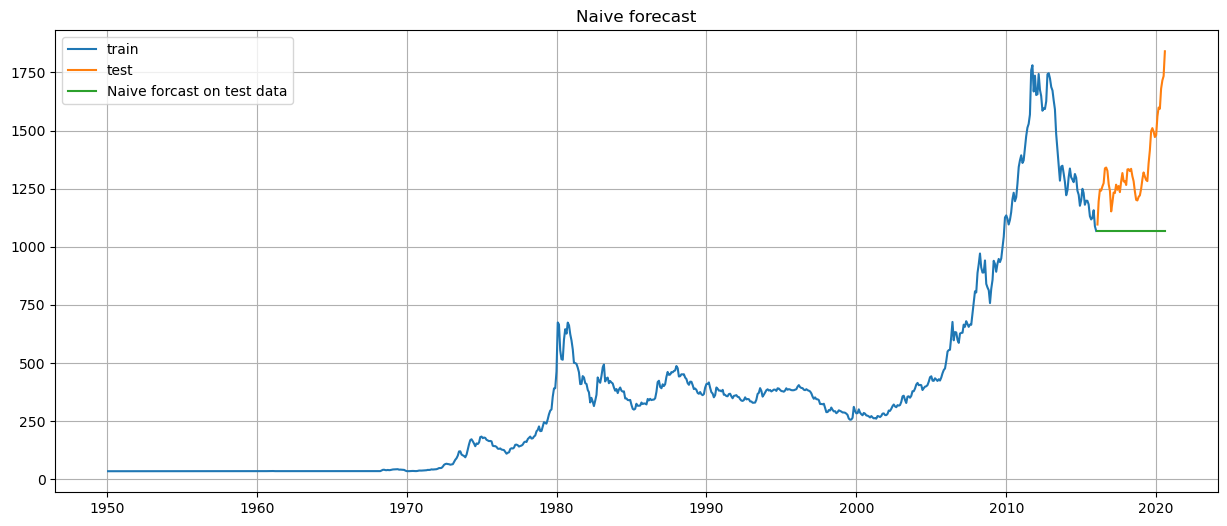

In [72]:
##plots

plt.figure(figsize=(15,6))
plt.plot(native_train['Price'], label='train')
plt.plot(test['Price'], label='test')
plt.plot(native_test['naive'], label='Naive forcast on test data')
plt.legend(loc = "best")
plt.title('Naive forecast')
plt.grid()

In [73]:
## mape

mape_model2_test = mape(test['Price'], native_test['naive'])
print("For naive forecast on the test data, MAPE is %3.3f" %(mape_model2_test), "%")

For naive forecast on the test data, MAPE is 19.380 %


In [75]:
resultsdf2 = pd.DataFrame({'Test MAPE (%)' : [mape_model2_test]}, index=['NaiveModel'])
results = pd.concat([results, resultsdf2])

results

,Test Mape (%),Test MAPE (%)
RegressionOnTime,29.76,NaN
NaiveModel,19.38,NaN
NaiveModel,NaN,19.38


In [76]:
## final model

final_model = ExponentialSmoothing(df,
                                  trend= 'additive',
                                  seasonal= 'additive').fit(smoothing_level= 0.4,
                                                           smoothing_trend=0.3,
                                                           smoothing_seasonal= 0.6)

In [77]:
Mape_final_model = mape(df['Price'], final_model.fittedvalues)

print("MAPE:", Mape_final_model)

MAPE: 17.24


In [78]:
# the predictions

prediction = final_model.forecast(steps=len(test))

In [80]:
## creating dataframe with confidence interval of 0.05 (95%)

pred_df = pd.DataFrame({'Lower CI' : prediction - 1.95 * np.std(final_model.resid, ddof=1),
                      'prediction' : prediction,
                      'Upper CI' : prediction + 1.95 * np.std(final_model.resid, ddof=1)})

pred_df.head()

,Lower CI,prediction,Upper CI
2020-08-31,1685.270065,1792.869246,1900.468428
2020-09-30,1615.853606,1723.452788,1831.051969
2020-10-31,1539.112670,1646.711851,1754.311033
2020-11-30,1477.300622,1584.899804,1692.498985
2020-12-31,1459.867000,1567.466182,1675.065363


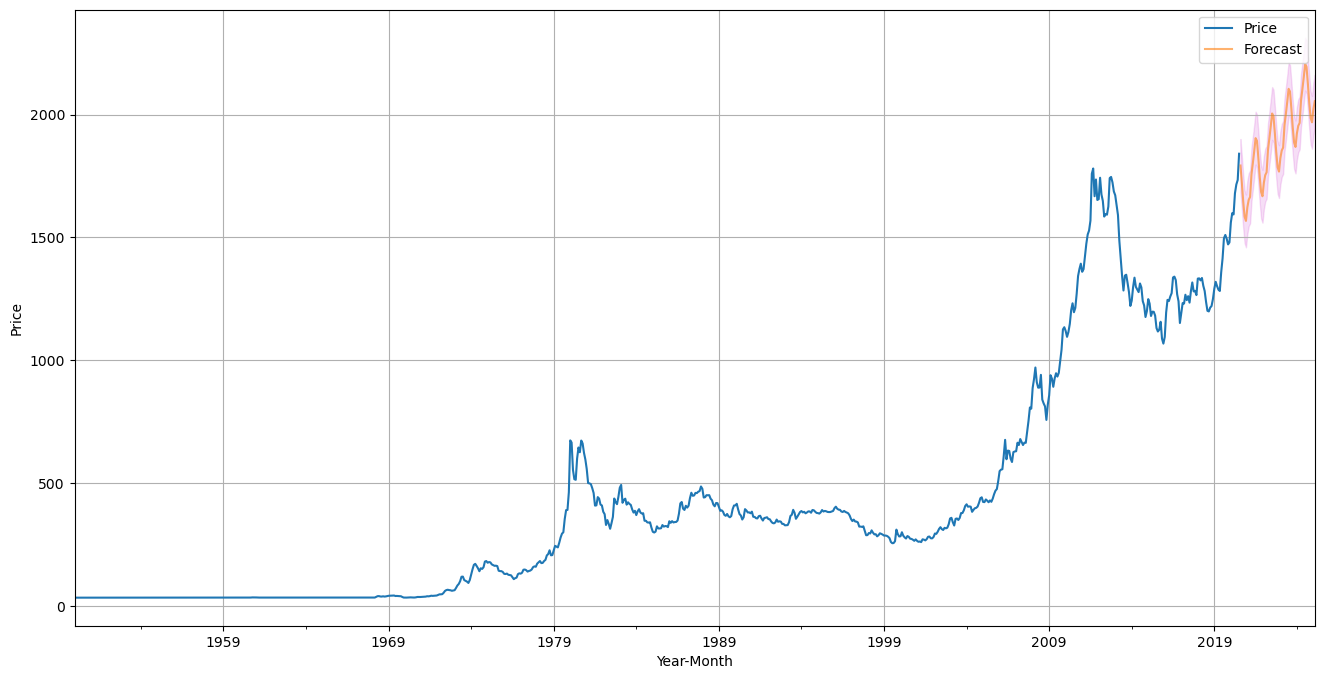

In [81]:
## lets plot

axis = df.plot(label= 'actual', figsize=(16, 8))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha = 0.6)

axis.fill_between(pred_df.index, pred_df['Lower CI'], pred_df['Upper CI'], color = 'm', alpha = .13)
axis.set_xlabel('Year-Month')
axis.set_ylabel('Price')
plt.legend(loc='best')
plt.grid()
plt.show()